In [389]:
import torch
import pickle
import random

from sklearn.metrics.pairwise import cosine_similarity

gcn_embed_weights = torch.load('./embed/exhird_h_normal_gcn_word_embed_cpu.pt')
normal_embed_weights = torch.load('./embed/exhird_h_normal_word_embed_cpu.pt')

with open('./vocab2idx.pkl', 'rb') as f:
    vocab2idx = pickle.load(f)
    f.close()

In [390]:
gcn_embed_weights.shape

torch.Size([50004, 100])

In [403]:
def get_random_words(vocab2idx, n):
    vocab = list(vocab2idx)
    return [vocab[random.randint(4, 50004)] for i in range(n)]

In [404]:
from collections import defaultdict
from tqdm import tqdm

def get_cosine_similarity(feature_vec_1, feature_vec_2):    
    return cosine_similarity(feature_vec_1.reshape(1, -1), feature_vec_2.reshape(1, -1))[0][0]

def get_top_k_from_embed(embed, words, vocab, k):
    words_idx = [vocab[word] for word in words]
    scores = dict({vocab[word]: [] for word in words})
    
    for word_idx in words_idx:
        for vocab_idx in tqdm(range(len(vocab))):
            if word_idx == vocab_idx: continue
            scores[word_idx].append((vocab_idx, get_cosine_similarity(embed[word_idx], embed[vocab_idx])))
            
    for score_idx in scores:
        scores[score_idx] = sorted(scores[score_idx], key=lambda x: x[1], reverse=True)[:k]
            
    return scores

In [405]:
# words = ['performance', 'optimal', 'homogeneous', 'subsequent', 'biomedical', 'involvement', 'nlp', 'dimensionality', 'hypothesis', 'coefficient']
# words = ['fundamental', 'optimal', 'homogeneous', 'coefficient', 'biomedical', 'involvement', 'nlp', 'dimensionality', 'hypothesis', 'message']
# words = ['fundamental', 'homogeneous', 'biomedical', 'dimensionality', 'hypothesis']
words = get_random_words(vocab2idx, 10)
print(words)
assert 10 == len(words)

['aortitis', 'ssmp', 'oef', 'rigorously', 'coated', 'semiconducting', 'partite', 'ergodicity', 'confluent', 'accelero']


In [406]:
gcn_similarity_scores = get_top_k_from_embed(gcn_embed_weights, words, vocab2idx, 50)

100%|██████████| 50004/50004 [00:13<00:00, 3599.00it/s]


In [407]:
baseline_similarity_scores = get_top_k_from_embed(normal_embed_weights, words, vocab2idx, 50)

100%|██████████| 50004/50004 [00:13<00:00, 3663.90it/s]


In [408]:
import pickle


with open('./gcn_tsne_seed_3435.pkl', 'rb') as f:
    gcn_embed_tsne = pickle.load(f)
    f.close()
    
with open('./normal_tsne_seed_3435.pkl', 'rb') as f:
    baseline_embed_tsne = pickle.load(f)
    f.close()

In [409]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

%matplotlib inline

In [410]:
labels = [list(vocab2idx)[idx] for idx in baseline_similarity_scores]

gcn_x, gcn_y = gcn_embed_tsne[:, 0], gcn_embed_tsne[:, 1]
baseline_x, baseline_y = baseline_embed_tsne[:, 0], baseline_embed_tsne[:, 1]

In [411]:
gcn_embed_tsne.shape

# import seaborn as sns

# sns.set_style('darkgrid')

(50004, 2)

In [432]:
import numpy as np

def tsne_plot_top_k(labels, embed, word_cluster, vocab, title=None):
    """
    embed => tsne_embed
    word_cluster => top_k cluster
    """
    plt.figure(figsize=(20, 15))

    colors = cm.rainbow(np.linspace(0.0, 1.0, len(labels)))
    vocab = list(vocab)
    
    data = np.array([embed[weights[0]] for word_cluster_idx in word_cluster for weights in word_cluster[word_cluster_idx]])
    
    for label, color, word_cluster_idx in zip(labels, colors, word_cluster):
        weights = np.array([embed[weights[0]] for weights in word_cluster[word_cluster_idx]])
        x = weights[:, 0]
        y = weights[:, 1]
        plt.scatter(x, y, color=color, alpha=0.7, label=label)
        for idx, weight in word_cluster[word_cluster_idx]:
            plt.annotate(
                vocab[idx], 
                alpha=0.5,
                xy=(embed[idx, 0], embed[idx, 1]), 
                xytext=(5, 2), textcoords='offset points', ha='right', va='bottom', size=10)
    if title:
        plt.title(title, pad=20, fontdict={'fontsize' : 20})
        
    plt.legend(loc=4)
    plt.grid(True)
    plt.show()

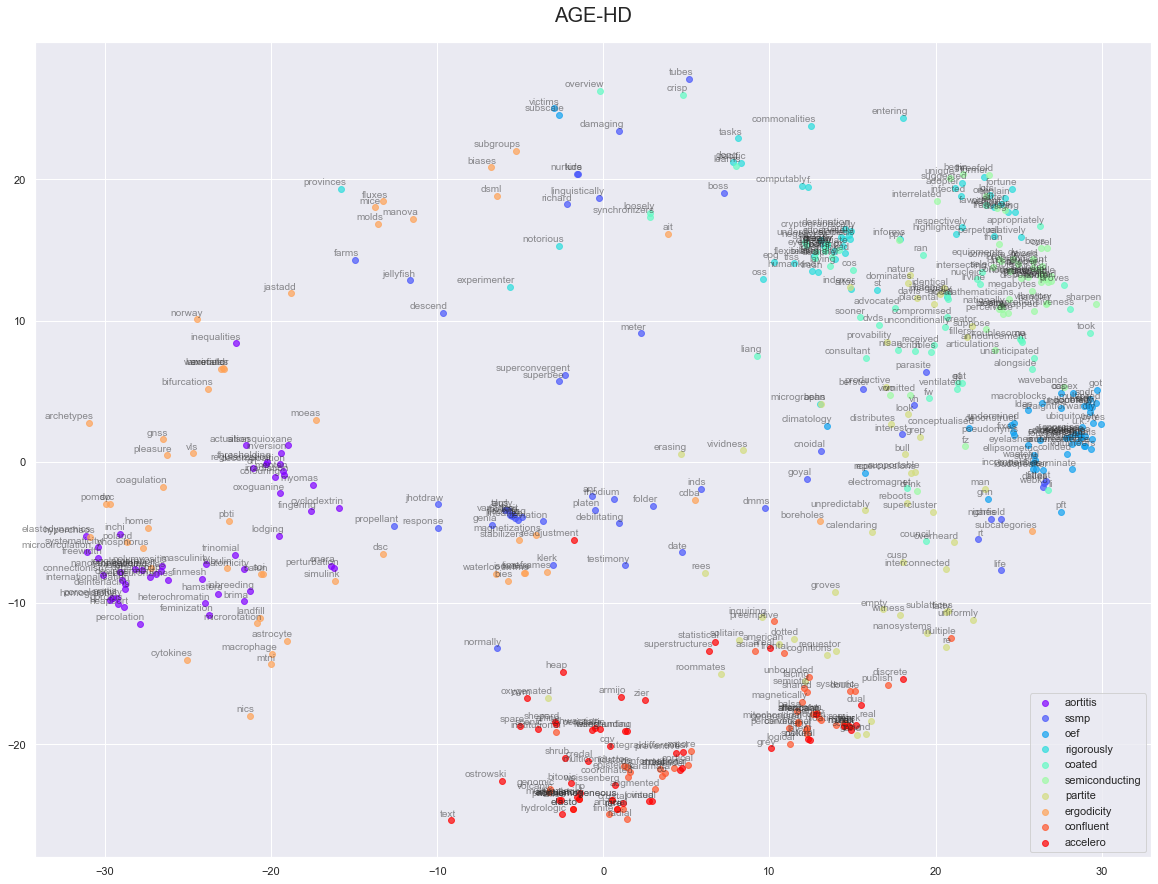

In [433]:
tsne_plot_top_k(labels, gcn_embed_tsne, gcn_similarity_scores, vocab2idx, title='AGE-HD')

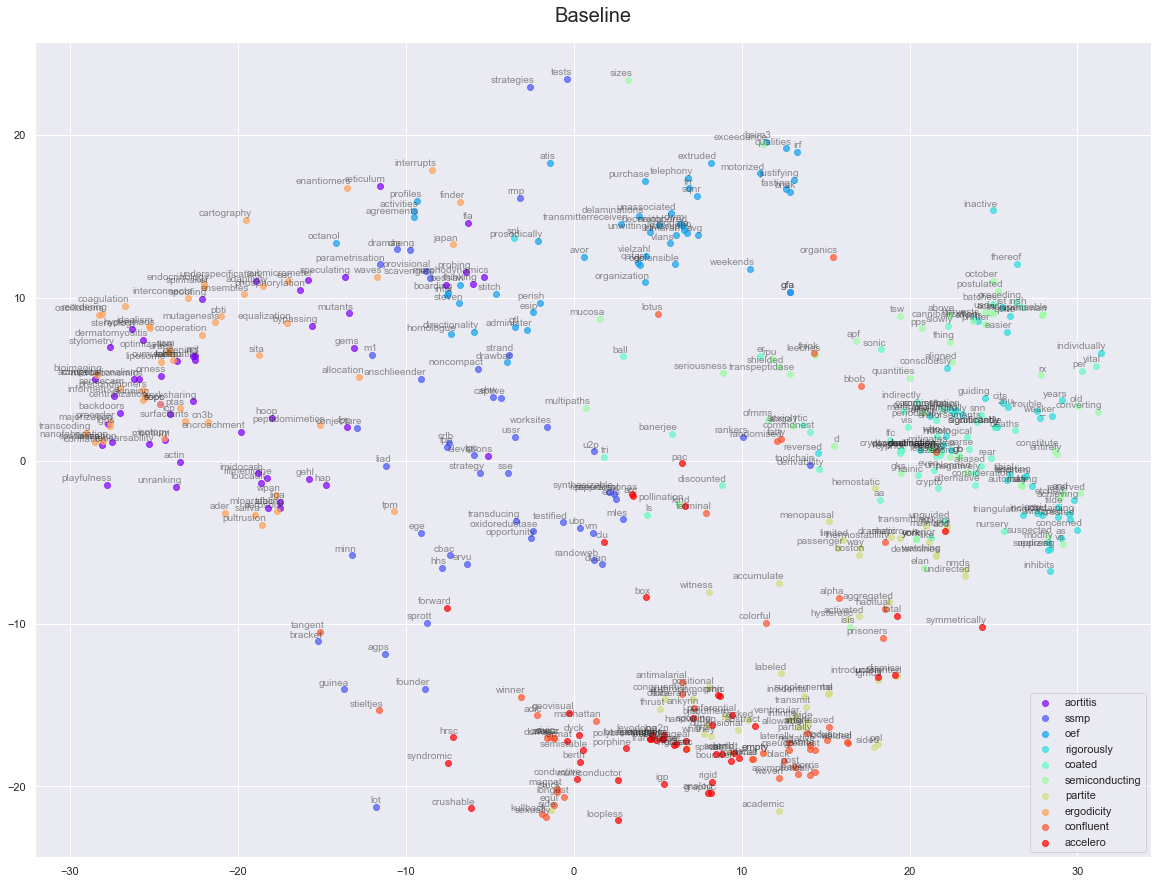

In [434]:
tsne_plot_top_k(labels, baseline_embed_tsne, baseline_similarity_scores, vocab2idx, title='Baseline')